## CPE Analysis Outline

This notebook summarzies the CPE analysis as of **4/27/2018**. The main goals are the following:

1) Understand the charge dynamics that give rise to the observed CPE phenomenon.

2) Bound the parameter values obtained from fitting the impedance data to a CPE model.

3) Relate these fit parameters to a physically meaningful picture.

As outlined by many authors, such as Brug [(10.1016/S0022-0728(84)80324-1)](https://www.sciencedirect.com/science/article/pii/S0022072884803241?via%3Dihub), a CPE is just a mathematical construct for fitting non-ideal data. It's definitive relation to physical charge dynamics is, at present, a more or less open question, but it is generally believed that the CPE originates from a distribution in current density within the sample being probed.

This distribution in current density has been posited to occur either horizontally across the surface of the electrode (notably by Brug, et. al., see above reference) or, more recently vertically in a direction normal to the electrode surface (e.g. Agarwal, et. al., doi: [10.1149/1.2069522](http://jes.ecsdl.org/content/139/7/1917.abstract) and a series of papers by Hirschorn, et. al, doi: [10.1149/1.3499565](http://jes.ecsdl.org/content/157/12/C458.abstract)).   

In the following, we use the analysis of Hirschorn et. al. to relate the CPE parameters to a distribution of resisitivty throughout the sample. First, we use a graphical analysis outlined by Orazem and coworkers ([ 10.1149/1.2168377](http://jes.ecsdl.org/content/153/4/B129.abstract)) to understand how exactly to recognize a CPE in the impedance data, and to generate effective estimates for CPE parameters for meaningful regressions to experimental data. 

Once we obtain these paremeters, we can estimate the resisitvity distribution that generates the CPE.

The hope is that once we collect everything here, we can scale the analysis as needed to generate temperature- or illumination-dependent models of minority carrier diffusion in forward bias in these samples. 


We begin by importing the data in the correct units below. **Units are *key* in this analysis**. Impedance $Z$ will be presented in $k\Omega cm^{2}$, meaning that $Q$ will acquire units of $k\Omega^{-1} cm^{-2} s^{\alpha}$. The units will be noted in comment blocks.

In [13]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
%matplotlib inline



importdata = np.genfromtxt('IS400.csv',delimiter=',');  #read in data that i output from matlab. input format has each
                                                        #of the 16 Temperature data sets stacked vertically. 
npoints = 101; #each T has 101 points
IS400 = np.zeros((16,npoints,5)) #Initialize new 3d array to hold data. note: first index is what we would traditionally 
                            #think of as the last index. it makes sense though when you think hierarchically,
                            #i.e. main list has 16 elements each of which has 101 smaller elements containing 5 elemnts. 
for i in range(0,16):
    IS400[i,:,:]=importdata[(npoints*i):(npoints*(i+1)) , :] #slice the data into subarrays  
    
## Function definitions

def Zr(T): #pulls out Z' in units of kOhm*cm^{2} (these are the standard units of impedance). Note that as is, the data is already in units of kOhm
    return IS400[T,:,3]*4e-2
def Zi(T): #pulls out Z'' in units of kOhm*cm^{2}
    return IS400[T,:,4]*4e-2
def w(T): #pulls out omega
    return IS400[T,:,0]



  
    


# 1. Obtaining CPE parameter estimates #


According to Orazem, et al [(10.1149/1.2168377)](http://jes.ecsdl.org/content/153/4/B129.abstract), we can use graphical analysis to make a qualitative and quantitative assessment of the physical processes revealed by impedance spectrra. Through consideration of the Nyquist plot and analysis of the real and imaginary components of the impedance $Z$ with respect to frequency $\omega$, we can characterize both the characteristic frequencies, CPE coefficient $Q$, and CPE exponent $\alpha$. We can then verify these data and run physical analysis on the processes that are represented by these parameters. 

We can do this via the following procedure:

1) **Inspect Nyquist plot**
    We want to see if there are physically distinct processes discernable in the complex plane and roughly determine if a CPE 
    is present
    
2) **Inspect $|Z|$ and $\phi$**
    The magnitude and phase angle in particular should tell explicitly reveal the presence of a CPE. For a CPE, the maximum 
    achievable $\phi < 90$, indicating that the impedance of the CPE isn't purely out of phase with the real part of the
    impedance like in a capacitor. 
   
3) **Look at Im(Z) vs. $\omega$**
    Peaks occur at characteristic frequencies, and on either side of the peak, the slope of the line should give an estimate 
    of $\alpha$. Once $\alpha$ is obtained, we should be able to estimate $Q$.
    
4) **Look at Re(Z) vs. $\omega$**
    The high frequency asymptote should allow an estimate for the series Ohmic resistance, $R_{s}$.
    
5) **Fit Nyquist Plots**
    Using parameters obtained from steps 2 and 3, see if we can generate a decent fit to the Nyquist plot.
    
    
Let's demonstrate this technique for a sample curve, say the 13th entry in the IS data array.
    

Text(0,0.5,'$-Z_{i}$ k$\\Omega cm^{2}$')

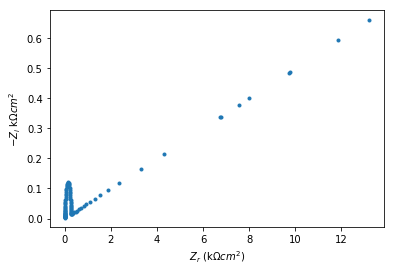

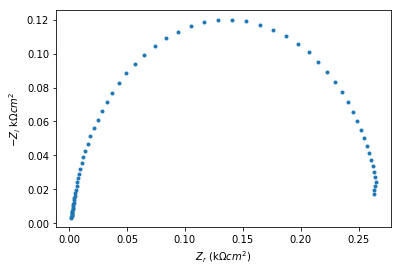

In [14]:
# Nyquist plot for the 13th curve.

fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[-96:],-Zi(12)[-96:],'.')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")

# ax.axis([0,8, 0,8])

fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")


# ax.axis([0,100, 0,8])


Ok, so the first plot looks like it's a depressed semicircle, which means there's probably a CPE involved. It doesn't look like there are too many other obvious processes (other than the straight line at low frequency), though the presence of a CPE suggests that there may be a smooth continuum of processes occuring. 

Now, let's look at the magnitude $|Z| vs. \omega$ and phase angle $\phi vs. \omega$.

Text(0.5,1,'$\\phi$ vs. $\\omega$')

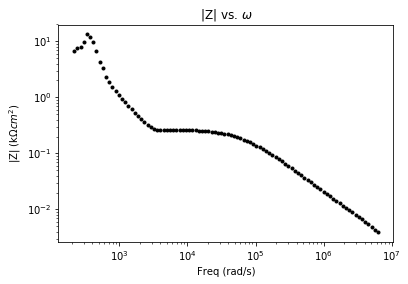

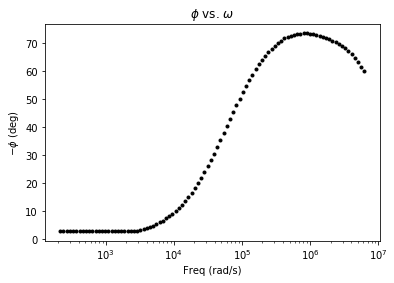

In [15]:
fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],np.sqrt(np.square(Zr(12)[-96:]) + np.square(Zi(12)[-96:])),'k.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);


fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],-np.arctan((Zi(12)[-96:])/(Zr(12)[-96:]))*(180/np.pi),'k.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);

From the phase angle plot, we see that at low frequency, the impedance components $R_{e}$ and the $R_{f}C/R_{f}Q$ network are in phase. As a result, the impedance is completely real at frequencies $\omega <4\times10^{3}$ rad/s. 

The plateau in the middle of the $|Z| vs. \omega$ plot comes from the fact that the $R_{f}C/R_{f}Q$ component starts becoming important $\sim 4 \times 10^{3}$ rad/s. The $R_{f}C/R_{f}Q$ compenent continues to dominates the impedance from this frequency onward, becoming maximally out of phase with $Re(Z) at $\omega > 10^{5}$ rad/s. Because we have a CPE, the max phase angle achieved is less than 90. 

Now, let's try and obtain estimates for $Q$ and $\alpha$ graphically according to the Orazem paper above.

0.00328052


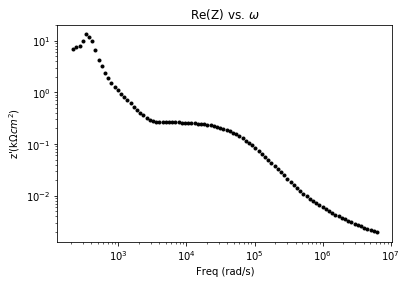

In [16]:
fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],Zr(12)[-96:],'k.')
ax.set_xlabel("Freq (rad/s)")
ax.set_ylabel("z'(k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,650]);

print(Zr(12)[-10])

ReEst = Zr(12)[-10]

There appear to be 2 different asymptotes. The highest frequency asymptote is levels out at a very low impedance (of order $3 \times 10^{-2} k \Omega cm^{2}$), whereas the mid-frequency plateau levels out around $3 \times 10^{-1} k \Omega cm^{2}$. We should correlate this data back to the Nyquist plot. But first, check $Im(Z) vs. \omega$. 

Text(0.5,1,'Im(Z) vs. $\\omega$')

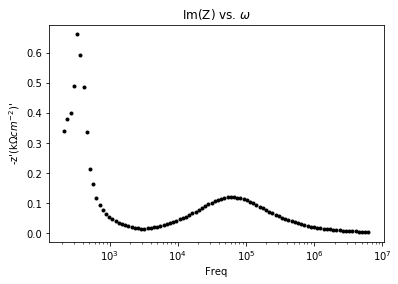

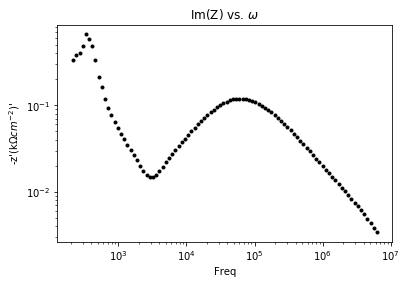

In [17]:
#Bode plot for imaginary part

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],abs(-Zi(12)[-96:]),'k.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'(k$\Omega cm^{-2}$)'")
ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],abs(-Zi(12)[-96:]),'k.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'(k$\Omega cm^{-2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);

So from the peak we see that the start of the first plateau in $Re(Z) vs. \omega$ corresponds to the inflection point in $Im(Z) vs. \omega$. The peak in $Im(Z) vs. \omega$ indicating a characterisitic frequency corresponds to the point of max slope after the first plateau in $Re(Z) vs. \omega$.

Before we dive too far into that, let's extract the slope on either side of the curve that corresponds to $\alpha$. Using $\alpha$, we can obtain $Q_{eff}$. Try using the gradient to extract the peak position, and then fitting lines on either side of that position.


Text(0.5,1,'Grad(Im(Z)) vs. $\\omega$')

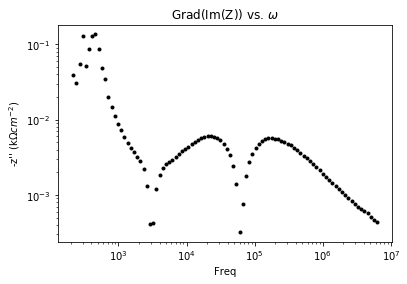

In [18]:
fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],abs(np.gradient(-Zi(12)[-96:])),'k.')
# ax.plot(w(12)[peak],abs(np.gradient(-Zi(12)[peak])),'r.')
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'' (k$\Omega cm^{-2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Grad(Im(Z)) vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);

Text(0.5,1,'Im(Z) vs. $\\omega$')

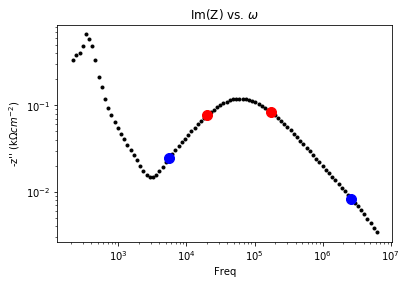

In [19]:
# locate all the important points for the linear fit

boundMin = np.argmax(w(12) > 3e3) + 5
boundMax = -1 - 8
peakRange = np.argmax(abs(Zi(12)[boundMin:boundMax]))
peak = peakRange + boundMin

peak1 = peak - 10
peak2 = peak + 10

# print(boundMin)
# print(boundMax)
# print(peak)
# print(abs(-Zi(12)[peak]))
# print(Zi(12).shape)
# print(w(12)[peak])
# print(w(12)[boundMin:boundMax])
# print(abs(Zi(12)[boundMin:boundMax]))
# print(np.argmax(abs(Zi(12)[boundMin:boundMax])))

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],abs((-Zi(12)[-96:])),'k.')
ax.plot(w(12)[peak1],abs((-Zi(12)[peak1])),'r.', markersize = 20)
ax.plot(w(12)[peak2],abs((-Zi(12)[peak2])),'r.', markersize = 20)
ax.plot(w(12)[boundMin],abs((-Zi(12)[boundMin])),'b.', markersize = 20)
ax.plot(w(12)[boundMax],abs((-Zi(12)[boundMax])),'b.', markersize = 20)
# ax.set_aspect('equal')
ax.set_xlabel("Freq")
ax.set_ylabel("-z'' (k$\Omega cm^{-2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")


0.900115173316 -11.447047472
-0.8612230806 7.97405427793
0.880669126958


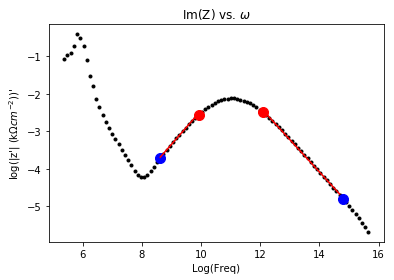

In [20]:
# run linear regressions on either side of peak to obtain \alpha

x1 = np.vstack( [np.log(w(12)[boundMin:peak1]), np.ones(len(w(12)[boundMin:peak1]))]).T
y1 = np.log(abs(Zi(12)[boundMin:peak1]))

m1,c1 = np.linalg.lstsq(x1,y1)[0]
print(m1,c1)

x2 = np.vstack( [np.log(w(12)[peak2:boundMax]), np.ones(len(w(12)[peak2:boundMax]))]).T
y2 = np.log(abs(Zi(12)[peak2:boundMax]))

m2,c2 = np.linalg.lstsq(x2,y2)[0]
print(m2,c2)



fig, ax = plt.subplots(1,1)
ax.plot(np.log(w(12)[-96:]),np.log(abs((-Zi(12)[-96:]))),'k.')
ax.plot(np.log(w(12)[peak1]),np.log(abs((-Zi(12)[peak1]))),'r.', markersize = 20)
ax.plot(np.log(w(12)[peak2]),np.log(abs((-Zi(12)[peak2]))),'r.', markersize = 20)
ax.plot(np.log(w(12)[boundMin]),np.log(abs((-Zi(12)[boundMin]))),'b.', markersize = 20)
ax.plot(np.log(w(12)[boundMax]),np.log(abs((-Zi(12)[boundMax]))),'b.', markersize = 20)

ax.plot(np.log(w(12)[boundMin:peak1]), m1*np.log(w(12)[boundMin:peak1]) + c1, 'r')

ax.plot(np.log(w(12)[peak2:boundMax]), m2*np.log(w(12)[peak2:boundMax]) + c2, 'r')

# ax.set_aspect('equal')
ax.set_xlabel("Log(Freq)")
ax.set_ylabel("log(|z'| (k$\Omega cm^{-2}$))'")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")

alpha = np.array([abs(m1),abs(m2)])
alpha = np.mean(alpha)
print(alpha)



Ok, so now we have an estimate for $\alpha$. Excellent.

Now let's solve for Q by using the Orazem paper cited above. We need to solve $Q_{eff} = sin(\frac{\alpha \pi}{2})\frac{-1}{Z_{j}(\omega)(2 \pi \omega)^{\alpha}}$. We then plot this vs. frequency. $Q_{eff}$ should assume it's apparent value above the characteristic frequency given by the peak in the $Im(Z) vs. \omega$ plot. 

84 0.000257600679502


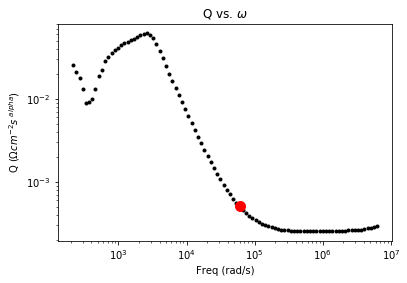

In [21]:
#calculate and estiamte Qeff

Qarray = np.sin((alpha*np.pi)/2)*(-1/(Zi(12)*w(12)**(alpha)))


fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],Qarray[-96:],'k.')
ax.plot(w(12)[peak],Qarray[peak],'r.', markersize = 20)

# ax.set_aspect('equal')
ax.set_xlabel("Freq (rad/s)")
ax.set_ylabel("Q ($\Omega cm^{-2} s^{\ alpha}$)")
ax.set_xscale("log") 
ax.set_yscale("log")
ax.set_title("Q vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);


wEff = np.argmax(w(12) > 1e6)
Qeff = Qarray[wEff]
print(wEff,Qeff)


In [22]:
# Estimate R_{f} from the resonance peak and the estimate of Q

RfEst = (1/w(12)[peak])/Qeff
print(RfEst)
print( (w(12)[peak])**(-alpha))

0.0647762742193
6.20129750603e-05


So now we have estimated $R_{e}$, $\alpha$, and $Q$. Now, let's try and fit the Nyquist plot using our parameter guesses extracted graphically above to see how well this analysis fits with the fitting procedure

In [23]:
# set up the objective function using the lmfit pacakge. The objective function we are defining in this case are the residuals
# for both the real and imaginary parts of Z. A single array of both real and imaginary residuals is sent to lmfit, which
# then mnimizes the sum of the square of this array.

def circuitModelQ(w,Re,Rf,Q,a):
    return Re+(Rf/(1+((1j*w)**a)*Q*Rf))

def circuitResidQ(params,w,Zr,Zi):
    parvals = params.valuesdict()
    Re = parvals['Re']
    Rf = parvals['Rf']
    Q = parvals['Q']
    a = parvals['a']
    ZrHat = np.real(circuitModelQ(w,Re,Rf,Q,a))
    ZiHat = np.imag(circuitModelQ(w,Re,Rf,Q,a))
    #model1 = np.sqrt(R/(1+(w/wk)**2))
    #model2 = -np.sqrt(R*w/(wk*(1+(w/wk)**2)))
    resid1 = ZrHat-Zr
    resid2 = ZiHat-Zi
    return np.concatenate((resid1,resid2))


Parameters([('Re', <Parameter 'Re', value=0.0024024845092032732 +/- 0.000155, bounds=[0:5]>), ('Rf', <Parameter 'Rf', value=0.26684686941894631 +/- 0.000306, bounds=[0:100]>), ('Q', <Parameter 'Q', value=0.00012070409713452097 +/- 1.48e-06, bounds=[0:0.001]>), ('a', <Parameter 'a', value=0.93564208179415886 +/- 0.00115, bounds=[0.6:1]>)])


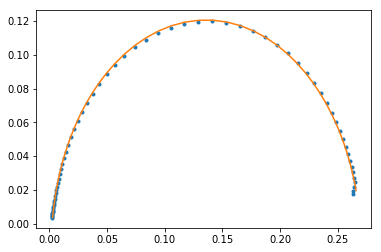

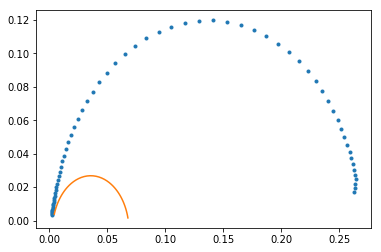

In [24]:
# run the fit for the first objective function

params = lmf.Parameters()  #add parameters with guesses
params.add('Re',value = ReEst, min = 0, max = 5)
params.add('Rf',value = RfEst, min = 0, max = 100)
params.add('Q',value = Qeff, min = 0, max = 1e-3)
params.add('a',value = alpha, min = .6, max = 1)


fit = lmf.minimize(circuitResidQ,params,args = (w(12)[32:],Zr(12)[32:],Zi(12)[32:]))
Refit = fit.params['Re'].value
Rffit = fit.params['Rf'].value
Qfit = fit.params['Q'].value
afit = fit.params['a'].value
fit.params

print(fit.params)

# plot the resulting fit
fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.plot(np.real(Refit+(Rffit/(1+((1j*w(12)[32:])**afit)*Qfit*Rffit))),-np.imag(Refit+(Rffit/(1+((1j*w(12)[32:])**afit)*Qfit*Rffit))))
# ax.set_aspect('equal')


# for comparison, plot the values extracted above
fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.plot(np.real(ReEst+(RfEst/(1+((1j*w(12)[32:])**alpha)*Qeff*RfEst))),-np.imag(ReEst+(RfEst/(1+((1j*w(12)[32:])**alpha)*Qeff*RfEst))))
# ax.set_aspect('equal')

In [29]:
from lmfit import Model
arcmodel = Model(circuitModelQ) #Note that this isn't actually just for a single R-CPE section, as it also has the
                                #constant Re in the function definition. easily fixed though. 
    
arc_params = arcmodel.make_params(Re = .001, Rf = .1, a = .9, Q = .0001) #making the params in the beginning is 
                                                                      # actually totally optional.You can feed guesses
                                                                    # as keyword arguments to the .fit method
        
data = Zr(12)[32:]+1j*Zi(12)[32:] #making the data complex, just makes the next line easier to read 

#this line does all the work. 
fit_result = arcmodel.fit(data,w= w(12)[32:],params= arc_params)
# the documentation for Model.fit() method is here: https://lmfit.github.io/lmfit-py/model.html#model-class-methods
# Most importantly, 
# 1) the first argument is the data (here, it's complex - ).

# 2) you can feed it a Parameters object with the 'params' keyword, but you don't have to, and can instead add guesses 
# as keyword arguments (i.e.adding an argument for each parameter in the call to 'fit'. 

# 3)It seems that you MUST feed it the independent variable as keyword argument (like i did in the above). 

#It's worth noting that the Model() function builds the general model from the functional form that we give it, and is
# smart enough to know how to name the parameters and variables. you can double check on the names with 
#'arcmodel.param_names' or 'arcmodel.independent_vars'
print(fit_result.fit_report())

[[Model]]
    Model(circuitModelQ)
[[Fit Statistics]]
    # function evals   = 76
    # data points      = 138
    # variables        = 4
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -1967.807
    Bayesian info crit = -1956.098
[[Variables]]
    Re:   0.00240248 +/- 0.000155 (6.46%) (init= 0.001)
    Rf:   0.26684686 +/- 0.000306 (0.11%) (init= 0.1)
    Q:    0.00012070 +/- 1.48e-06 (1.23%) (init= 0.0001)
    a:    0.93564210 +/- 0.001147 (0.12%) (init= 0.9)
[[Correlations]] (unreported correlations are <  0.100)
    C(Q, a)                      = -0.989 
    C(Rf, a)                     = -0.732 
    C(Rf, Q)                     =  0.699 
    C(Re, Rf)                    = -0.665 
    C(Re, a)                     =  0.508 
    C(Re, Q)                     = -0.426 



In [27]:
print(Refit, Rffit, Qfit,afit) #these are the values fit the old way.note that the new ones (above) are exactly the same. 

0.0024024845092 0.266846869419 0.000120704097135 0.935642081794


In [12]:
## this was just testing
testa = np.array([1,2,3])
testb = np.array([4,5,6])
testc = testa+1j*testb
testd = testc - (.1+1j*.1)
diff = testc-testd
diff=diff.ravel().view(np.float)
np.asarray(diff).ravel()

array([ 0.1,  0.1,  0.1,  0.1,  0.1,  0.1])

So, it seems like the graphical extraction method is *pretty* close to what shakes out of the Nyquist plot.

Specifically, the way we've estimated $R_{e}$ yields a value that does not agree with the fit. This might be OK--in both cases, $R_{e}$ is very small, so maybe this is just a way of noting that it's negligible in this bias regime. 

We did not really obtain a meaningul value for $R_{f}$ graphically, but it's value ($R_{f} \approx 0.3 k\Omega cm^{2}$) seems pretty reasonable. Note that, for whatever reason, it's close to the value of $|Z|$ in the mid-frequency plateau. I'm not sure if that's meaningful or just a coincidence.

Luckily, our value for $\alpha$ agrees almost precisely with the estimated value--we obtain $\alpha = 0.88$ graphically, and $\alpha = 0.89$ from the fit. Similarly, we obtain $Q = 1.76 \times 10^{4} k \Omega^{-1} cm^{-2} s^{\alpha}$ graphically, and  $Q = 2.57 \times 10^{4} k \Omega^{-1} cm^{-2} s^{\alpha}$ from the fit. 

Now let's use the fit values to make sense of the RC time constant. 

From Brug, et. al and Hirschorn and Orazem ([10.1016/j.electacta.2009.10.065](https://www.sciencedirect.com/science/article/pii/S0013468609013413)), the time constant $\tau_{0}$ in the presence of a CPE is given by $\tau^{\alpha} = QR_{f}$. So let's calculate $\tau$ based on our fit values.
   

1.59851263726e-05
66778.0


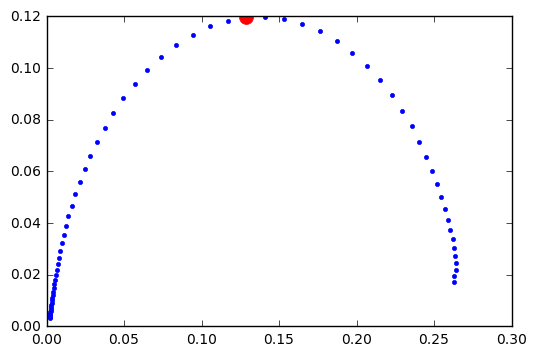

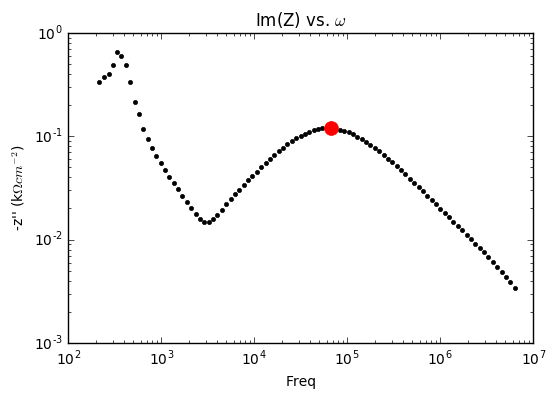

In [25]:
t0 = (Qfit*Rffit)**(1/afit)
print(t0)

wt0 = np.argmax(w(12) > (1/t0))
print(w(12)[wt0])

fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.plot(Zr(12)[wt0],-Zi(12)[wt0],'r.', markersize = 20)

fig, ax = plt.subplots(1,1)
ax.plot(w(12)[-96:],abs((-Zi(12)[-96:])),'k.')
ax.plot(w(12)[wt0],abs((-Zi(12)[wt0])),'r.', markersize = 20)
ax.set_xlabel("Freq")
ax.set_ylabel("-z'' (k$\Omega cm^{-2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")




Wow! Ok, so we can reliably extract the characteristic lifetime $\tau_0$, and it appears exactly where it should in both the Nyquist and Im(z) plots! 

This is really cool.

Now, let's see if we can relate the parameters extracted via this analysis to transport physics within the device. 

We will attempt to link these quantities by a method first outlined by Hirschorn and Orazem [(10.1149/1.3499565)](http://jes.ecsdl.org/content/158/12/C424.abstract?utm_source=TrendMD&utm_medium=cpc&utm_campaign=Journal_of_The_Electrochemical_Society_TrendMD_0) in wich CPE behavior is posited to be the result of a **power law distrinution of resisitivies** throughout the film thickness. This theory may be applicable in our case because it explicitly addresses variations in resistivity and transport along the axis normal to the electrode surface, and we know that transport in QD films is highly local.

It will be interesting to see if this matches with the intuition we have about transport in the ZnO layer vs. transport the in the PbS layer. In particular, we expect the ZnO part to have a lower resistivity $\rho$ than the PbS layer. Is this seen in the data? Does this imply that charge transfer at the junction is the rate limiting step? Does the CPE result from loss due to surface states at this interface?

To formalize this analysis, we will certainly need the following information:

1) film thickness

2) total stack dielectric constant

For now, let's simply assume a uniform PbS/ZnO device of thickness $\delta = 300$ nm or so and $\varepsilon = 12\varepsilon_{0}$. We can ammend this data later.

To complete this analysis, we will do the following:

1) Calculate the resistivity at one boundary $\rho_{\delta}$ using the following equation from the Hirschorn paper:
    $Q_{eff} = \frac{(\epsilon\varepsilon_{0})^{\alpha}}{g \delta \rho_{\delta}^{(1-\alpha)}}$. Here, $\delta$ is the film 
    thickness, and $g = 1 + 2.88(1-\alpha)^{2.375}$ as determined numerically by Hirschorn, et. al.
    
2) See if we can esimate the resisitivy at the other boundary $\rho_{0}$, by considering the DC limit of the impedance and the following equation: $Z(\omega = 0) = \frac{(\rho_{0} \varepsilon \varepsilon_{0})^{\alpha}}{Q_{eff}}$

3) Plug these values into the following proposed power law distribution:
    $\frac{\rho}{\rho_{\delta}} = (\frac{\rho_{\delta}}{\rho_{0}} + (1 - \frac{\rho_{\delta}}{\rho_0}) \xi^{\gamma})^{-1}$
    Here, $\xi = \frac{x}{\delta}$ is a dimensionless position parameter, and $\gamma$ is defined in terms of $\alpha$: $\alpha = \frac{1-\gamma}{\gamma}$.
    
The end goal of this is to get some idea of how all of this hangs together. From there, we can see how far we want to pursue these ideas. 


Let's start by calculating $\rho_{\delta}$. Do this for the $Q$ and $\alpha$ parameters obtained by the fit and graphical analysis (appended 1 and 2 in the code, respectively), but I will only refer to the fit parameters in the markdown comments.

In [27]:
# calculate \rho_{\delta} in units of ohm*cm

epsilon0 = 8.854e-14
epsilon = 12
gFac = 1 + (2.88*(1-afit)**(2.375))
delta = 300e-7

#note the units on Q!
rhoD1 = ( ((epsilon*epsilon0)**(afit))/(gFac * delta * Qfit*1e-3))**(1/(1-afit))
rhoD2 = ( ((epsilon*epsilon0)**(alpha))/(gFac * delta * Qeff*1e-3))**(1/(1-alpha))

print(rhoD1, 1/(1-afit))
print(rhoD2, 1/(1-alpha))




90228.2901864 9.99999999938
51079.742543 8.3800610396


After wrangling around with the units for quite some time, we get $\rho_{\delta} \approx 9.0 \times 10^{4} \Omega cm$.

Now we need to calculate $\rho_{0}$. Do this by taking the DC limit ($Z(\omega = 0)$), which according to Hirschorn should be  related to $\rho_{0}$ via the equation in point (2) above. So we're going to need to inspect the JV curve for this device and extract the DC resistance at 400mV applied bias to match the bias applied during the impedance measurement.

[ 1398.8080407]
[ 92106185.94502144] [  1.15828944e+08]


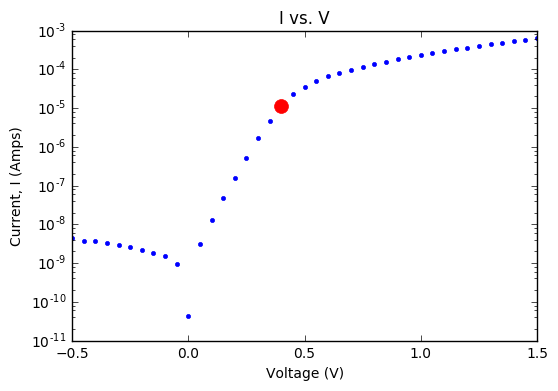

In [28]:
# import and plot IV  or JV data. extract the current at the point of interest. calculate the resulting impedance.
# then, calculate $\rho_{0}$

ivData = np.genfromtxt('dev1_fullrange_300K.txt')

# print(ivData)
# print(ivData.shape)
# print(ivData[0:41])


# initialize new array, with first column for voltage data and second column for current data
iv = np.zeros((2,41))
jv = np.zeros((2,41))

iv[0,:] = ivData[0:41]
iv[1,:] = ivData[41:]

# define an array for current density
jv[0,:] = iv[0,:]
jv[1,:] = (1e3*iv[1,:])/4e-2

# print(jv[0,:])

# calculate the DC impedance at V = 400mV, z0, in units of Ohm cm^{-2}
poi = np.where(iv[0,:] == 0.4)[0]
i0 = iv[1,poi]
z0 = ((iv[0,poi]/iv[1,poi])*4e-2)

print(z0)

# plot the IV data and label the point of interest
fig,ax = plt.subplots(1,1)
ax.plot(iv[0,:],abs(iv[1,:]),'.')
ax.plot(iv[0,poi],abs(iv[1,poi]),'r.',markersize = 20)
ax.set_xlabel("Voltage (V)")
ax.set_ylabel("Current, I (Amps)")
ax.set_yscale("log") 
ax.set_title("I vs. V")


rho01 = ( ((Qfit*1e-3)*z0)**(1/afit))/(epsilon*epsilon0)
rho02 = ( ((Qeff*1e-3)*z0)**(1/alpha))/(epsilon*epsilon0)

print(rho01, rho02)



We obtain $\rho_{0} = 9.21\times 10^{7} \Omega cm$. This is high, but higher values were obtained by CPE analysis in the references above.

At this point, it might be helpful to try and understand why $\rho$ at both ends of the distribution is so large. Is this reasonable for a semiconductor?

Well, I would say it depends on the frequency range in which you are interrogating charge transport. From the first Hirschorn paper above, we know that the CPE is only a good model in a frequncy range determined by the resisitivies above. We can compute this frequency range by determining the dielectric relaxation frequencies associated with $\rho_{0}$ and $\rho_{\delta}$. Specifically, $\omega_{0} = (\rho_{0}\varepsilon \varepsilon_{0})^{-1}$, and likewise $\omega_{\delta} = (\rho_{\delta}\varepsilon \varepsilon_{\delta})^{-1}$.

Let's see what these frequencies are:


[ 10218.57736837] 9576679.9824
41 0


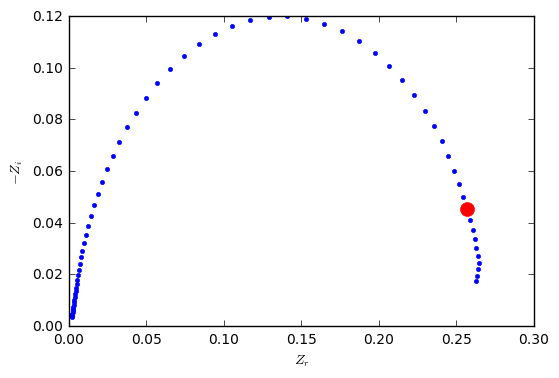

In [34]:
omega0 = 1/(rho01*epsilon*epsilon0)
omegaD = 1/(rhoD1*epsilon*epsilon0)

print(omega0,omegaD)


# re-plot the Nyquist plot highlighting available frequencies

w0 = np.argmax(w(12)>omega0)
wD = np.argmax(w(12)>omegaD)
print(w0, wD)

fig,ax = plt.subplots(1,1)
ax.plot(Zr(12)[32:],-Zi(12)[32:],'.')
ax.plot(Zr(12)[w0],-Zi(12)[w0],'r.',markersize = 20)
ax.set_xlabel("$Z_{r}$")
ax.set_ylabel("$-Z_{i}$")
# ax.axis([0,8, 0,8])

So these frequencies extend from $\omega = 10^{4}$ rad/s to just beyond the frequency range of the experiment. Meaning, the charge dynamics that give rise to the CPE are only operating at frequencies above $10^{4}$ rad/s, which is above the frequency at which the charge trapped in defects in the depletion region observed in the admittance measurement stop responding.

So, perhaps it makes sense that the resistivities are so high--a lot of the carriers that we see in these devices are frozen out! Only a small fraction of the charge in the device can move at these frequencies, even at significant forward bias.

I think this data is telling us that the diffusion of minority carriers that give rise to the impedance data here is still dominated by trapped carriers. The CPE is consistent with an imperfect dielectric with a resisitivty distribution $\rho$. The resistivity distribution mirrors the distribution of charge trapped in deep defect states, which causes high loss in both the real and imaginary impedance responses.



The next thing we need to do is see if we can make sense of the resistivity distribution explicitly. It would be great to see how all of these parameters change with temperature, voltage, and perhaps illumination. We can obviously relate these data to any of the TAS/DLCP stuff we have on hand already.

As I see it, the major questions we *may* be able to answer here are:

1) At high voltages past $V_{oc}$, are the charge dynamics still similar? Does the distribution $\rho$ change significantly?

2) How do these dyanmics evolve with temperature? Does that tell us about anomolous diffusion mechanisms in this system?

3) What about under illumnation? Do the charge dynamics chage significantly then? Does that imply different energetic states are being accessed?